In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### Import local modules

In [2]:
import os
import sys
module_path_lupft = '/home/glemieux/Repos/NGEET/fates/tools/landuse/src/landusepft/'
sys.path.append(module_path_lupft)
from landusepftmod import ImportLandusePFTFile, ImportStaticLUH2File
from landusepftmod import RenormalizePFTs, AddLatLonCoordinates, DefineMask
module_path_luh2 = '/home/glemieux/Repos/NGEET/fates/tools/luh2/'
sys.path.append(module_path_luh2)
from luh2mod import SetMaskSurfData, SetMaskLUH2, ImportData

### Define helper plot function

In [3]:
def plotnatpft(variable, colormap='magma_r'):
    fg = variable.plot(x='lon',y='lat',col='natpft', col_wrap=4, cmap=colormap, 
                   transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), add_colorbar=False)

    for ax in fg.axes.flat:
        ax.coastlines() 

    # color bar
    fg.add_colorbar(orientation="vertical", shrink=0.6, anchor=(1.5, 0.5))
    plt.subplots_adjust(hspace=-0.65)

### Import data

In [18]:
luh2_static_file = '/home/glemieux/Data/luh2/staticData_quarterdeg.nc'
regrid_target_file = '/home/glemieux/Data/surfdat/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc'
clm_surface_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_surf_deg025.nc'
clm_forest_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhforest_deg025.nc'
clm_pasture_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhpasture_deg025.nc'
clm_other_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhother_deg025.nc'
filelist = [clm_surface_file, clm_forest_file, clm_pasture_file, clm_other_file]

In [19]:
ds_static = ImportData(luh2_static_file)

Input file dataset opened: /home/glemieux/Data/luh2/staticData_quarterdeg.nc


In [20]:
ds_target = ImportData(regrid_target_file)

Input file dataset opened: /home/glemieux/Data/surfdat/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc
PrepDataset: SurfData
Surface dataset dimensions renamed for xESMF
data set updated for xESMF



In [21]:
ds_clmsurf = ImportLandusePFTFile(clm_surface_file)

In [22]:
ds_forest = ImportLandusePFTFile(clm_forest_file)

In [23]:
ds_forest

<xarray.Dataset>
Dimensions:      (natpft: 15, cft: 64, lat: 720, lon: 1440)
Coordinates:
  * natpft       (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * cft          (cft) int32 15 16 17 18 19 20 21 22 ... 71 72 73 74 75 76 77 78
Dimensions without coordinates: lat, lon
Data variables:
    EDGEN        float64 90.0
    EDGEE        float64 180.0
    EDGES        float64 -90.0
    EDGEW        float64 -180.0
    LAT          (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
    LATIXY       (lat, lon) float32 -89.88 -89.88 -89.88 ... 89.88 89.88 89.88
    LON          (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    LONGXY       (lat, lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
    LANDMASK     (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    LANDFRAC     (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    AREA         (lat, lon) float32 3.379 3.379 3.379 ... 4.742e-14 4.742e-14
    PCT_NAT_PFT  (natpft, lat, lon) float64 100.0 100.0 100.0 ... 0.0 0.0 0.0
Attributes:
    source:         Peter Lawrence, NCAR
    creation_date:  Thu Jun 15 14:53:15 MDT 2017
    title:          CLM5_current_luhforest_deg025.nc

In [13]:
((ds_forest.lon *.25 - 180. + 1./8.) == ds_forest.LON).all()

<xarray.DataArray ()>
array(True)

In [14]:
((ds_forest.lat *.25 - 90. + 1./8.) == ds_forest.LAT).all()

<xarray.DataArray ()>
array(True)

### Prep data

In [24]:
# Set the surface dataset mask
ds_target = SetMaskSurfData(ds_target)

In [25]:
# Add lat/lon coordinates for the clm5 datasets and add mask
AddLatLonCoordinates(ds_forest);
AddLatLonCoordinates(ds_clmsurf);
# SetMaskLUH2(ds_forest,ds_static)

In [26]:
ds_forest

<xarray.Dataset>
Dimensions:      (natpft: 15, cft: 64, lat: 720, lon: 1440)
Coordinates:
  * natpft       (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * cft          (cft) int32 15 16 17 18 19 20 21 22 ... 71 72 73 74 75 76 77 78
  * lon          (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat          (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
Data variables:
    EDGEN        float64 90.0
    EDGEE        float64 180.0
    EDGES        float64 -90.0
    EDGEW        float64 -180.0
    LAT          (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
    LATIXY       (lat, lon) float32 -89.88 -89.88 -89.88 ... 89.88 89.88 89.88
    LON          (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    LONGXY       (lat, lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
    LANDMASK     (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    LANDFRAC     (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    AREA         (lat, lon) float32 3.379 3.379 3.379 ... 4.742e-14 4.742e-14
    PCT_NAT_PFT  (natpft, lat, lon) float64 100.0 100.0 100.0 ... 0.0 0.0 0.0
Attributes:
    source:         Peter Lawrence, NCAR
    creation_date:  Thu Jun 15 14:53:15 MDT 2017
    title:          CLM5_current_luhforest_deg025.nc

In [27]:
mask_clmsurf = xr.where(ds_clmsurf.PCT_NATVEG > 0.,1,0)

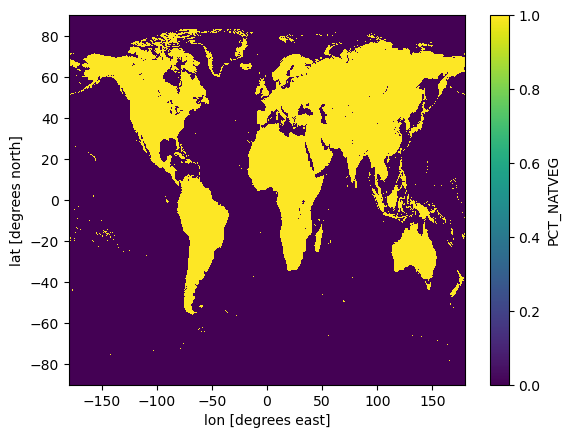

In [28]:
mask_clmsurf.plot()

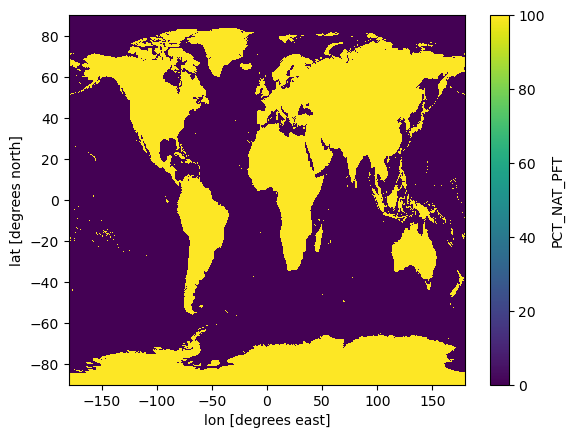

In [29]:
da_forest_sum = ds_forest.PCT_NAT_PFT.sum(dim='natpft')
da_forest_sum.plot()

In [30]:
da_forest_sum

<xarray.DataArray 'PCT_NAT_PFT' (lat: 720, lon: 1440)>
array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])
Coordinates:
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88

### Start percentage list and calculate bareground percentage

In [31]:
percent_bareground = ds_forest.PCT_NAT_PFT.isel(natpft=0)
percent_bareground = (percent_bareground / 100.0)

### Renormalized CLM5 data and mask data

In [32]:
percent_forest = RenormalizePFTs(ds_forest)

In [33]:
ds_percent_forest = percent_forest.to_dataset()

In [34]:
# Mask the forest sum data array
# SetMaskLUH2(ds_forest_sum, ds_static)

In [35]:
# Try setting the mask with per natpft dimensions

In [36]:
mask_static_luh2 = xr.where(ds_static.icwtr != 1,1,0)

In [37]:
mask_static_luh2

<xarray.DataArray 'icwtr' (lat: 720, lon: 1440)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat      (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88

In [38]:
# ds_percent_forest["mask"] = mask_static_luh2
ds_percent_forest["mask"] = mask_clmsurf   # This results in the same value of regrid

In [39]:
ds_percent_forest

<xarray.Dataset>
Dimensions:      (natpft: 14, lon: 1440, lat: 720)
Coordinates:
  * natpft       (natpft) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * lon          (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat          (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
Data variables:
    PCT_NAT_PFT  (natpft, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    mask         (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

### Calculate the primary and secondary PFT fractions as the forest

In [40]:
# Skip this for now
# percent[2] = ds_static.fstnf * percent[2] + (1. - ds_static.fstnf) * percent[-1]

### Regrid the dataset

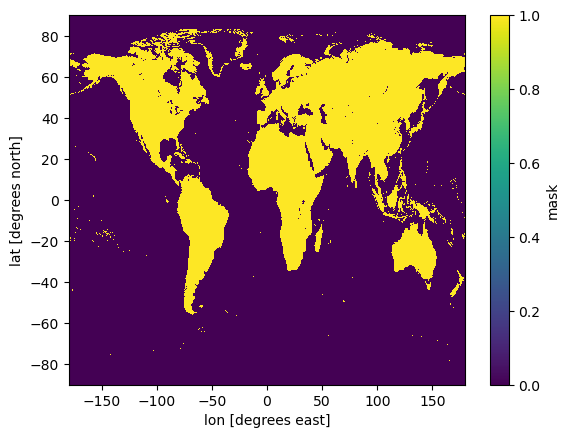

In [41]:
ds_percent_forest.mask.plot()

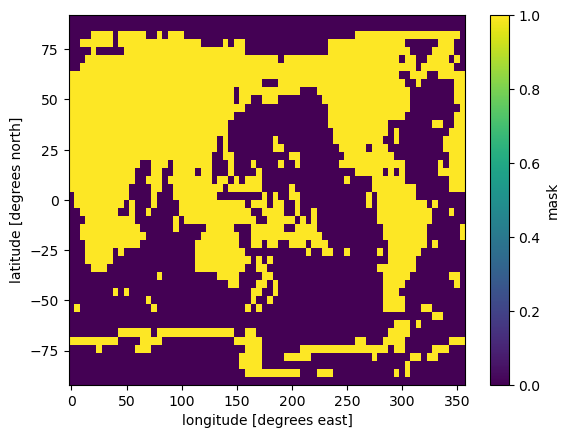

In [42]:
ds_target.mask.plot()

In [43]:
regridder = xe.Regridder(ds_percent_forest, ds_target, "conservative")
# regridder = xe.Regridder(ds_percent, ds_target, "conservative_normed")
ds_regrid = regridder(ds_percent_forest)

/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


### Review the regridded data

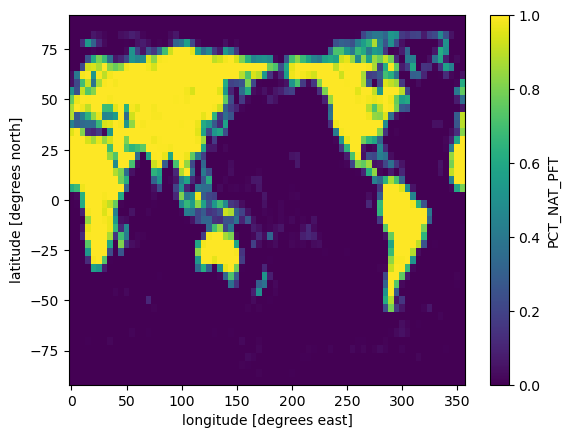

In [44]:
ds_regrid.PCT_NAT_PFT.sum(dim='natpft').plot()

### Try regridding only the sum to see if the issue is that we need `natpft` dimensionality on the mask

In [45]:
da_forest_sum["mask"] = mask_clmsurf

In [46]:
da_forest_sum

<xarray.DataArray 'PCT_NAT_PFT' (lat: 720, lon: 1440)>
array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])
Coordinates:
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
    mask     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

In [47]:
regridder = xe.Regridder(da_forest_sum, ds_target, "conservative")
# regridder = xe.Regridder(ds_percent, ds_target, "conservative_normed")
ds_regrid_sum = regridder(da_forest_sum)

/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


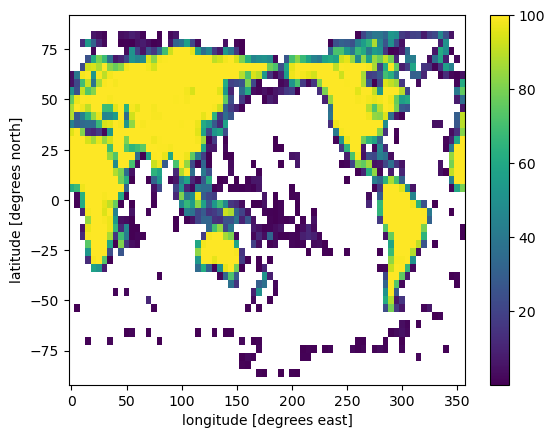

In [48]:
ds_regrid_sum.plot()

### What about conservative norming?

### Try adding lat bounds to input?

In [49]:
ds_states = xr.open_dataset('/home/glemieux/Data/luh2/states.nc',decode_times=False)

In [50]:
ds_states.lon_bounds[0,:].data

array([-180.  , -179.75])

In [51]:
(ds_states.lon == ds_static.lon).all()

<xarray.DataArray 'lon' ()>
array(True)

In [52]:
ds_static.lon_bounds[0,:].data

array([-180.125, -179.875], dtype=float32)

In [53]:
ds_static.lat_bounds[0,:].data

array([89.875, 89.625], dtype=float32)

**Aside: Why isn't the luh2 static data bounds the same as the luh2 transient data?**  It seems like the luh2 static bounds are wrong.

In [54]:
(ds_forest.LON == ds_forest.LONGXY).all()

<xarray.DataArray ()>
array(True)

### Review the regridded data

In [55]:
ds_forest_sum = da_forest_sum.to_dataset()

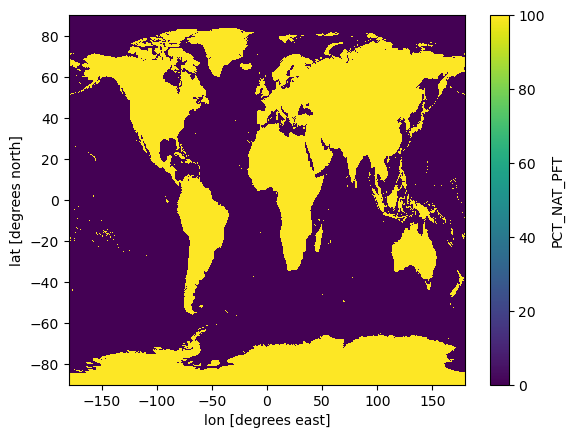

In [56]:
ds_forest_sum.PCT_NAT_PFT.plot()

In [57]:
np.insert(ds_states.lon_bounds[:,1].data,0,ds_states.lon_bounds[0,0].data)

array([-180.  , -179.75, -179.5 , ...,  179.5 ,  179.75,  180.  ])

In [73]:
ds_forest_sum["lat_b"] = np.flip(np.insert(ds_states.lat_bounds[:,1].data,0,ds_states.lat_bounds[0,0].data))
ds_forest_sum["lon_b"] = np.insert(ds_states.lon_bounds[:,1].data,0,ds_states.lon_bounds[0,0].data)

In [74]:
regridder = xe.Regridder(ds_forest_sum, ds_target, "conservative")
# regridder = xe.Regridder(ds_percent, ds_target, "conservative_normed")
ds_regrid_sum_new = regridder(ds_forest_sum)

/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


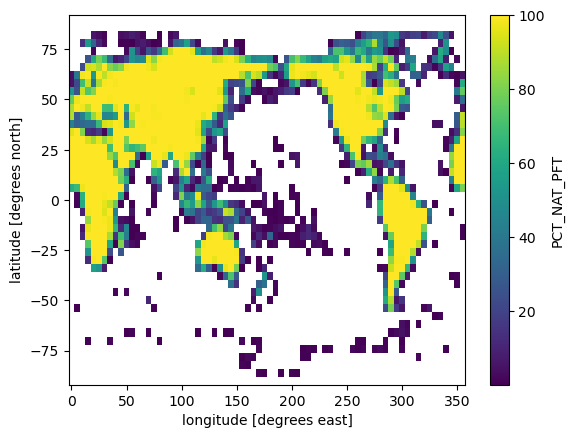

In [75]:
ds_regrid_sum_new.PCT_NAT_PFT.plot()

In [62]:
ds_states_import = ImportData('/home/glemieux/Data/luh2/states.nc')

Input file dataset opened: /home/glemieux/Data/luh2/states.nc
PrepDataset: LUH2
LUH2 dataset lat/lon boundary variables formatted and added as new variable for xESMF
data set updated for xESMF



In [63]:
ds_states_import

<xarray.Dataset>
Dimensions:    (time: 1166, lat: 720, lon: 1440, lat_b: 721, lon_b: 1441)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 ... 1.163e+03 1.164e+03 1.165e+03
  * lat        (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon        (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat_b      (lat_b) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon_b      (lon_b) float64 -180.0 -179.8 -179.5 -179.2 ... 179.5 179.8 180.0
Data variables: (12/15)
    primf      (time, lat, lon) float32 ...
    primn      (time, lat, lon) float32 ...
    secdf      (time, lat, lon) float32 ...
    secdn      (time, lat, lon) float32 ...
    urban      (time, lat, lon) float32 ...
    c3ann      (time, lat, lon) float32 ...
    ...         ...
    c3nfx      (time, lat, lon) float32 ...
    pastr      (time, lat, lon) float32 ...
    range      (time, lat, lon) float32 ...
    secmb      (time, lat, lon) float32 ...
    secma      (time, lat, lon) float32 ...
    timesince  int64 850
Attributes: (12/17)
    host:              UMD College Park
    comment:           LUH2
    contact:           gchurtt@umd.edu, lchini@umd.edu, steve.frolking@unh.ed...
    creation_date:     2016-10-12T18:26:36Z
    title:             Land-Use Harmonization Data Sets
    activity_id:       input4MIPs
    ...                ...
    further_info_url:  http://luh.umd.edu
    frequency:         yr
    institution_id:    UofMD
    institution:       University of Maryland College Park
    realm:             land
    references:        Hurtt, Chini et al. 2011

In [76]:
ds_target

<xarray.Dataset>
Dimensions:                  (lat: 46, lon: 72, nlevsoi: 10, natpft: 15,
                              cft: 2, time: 12, lsmpft: 17, numurbl: 3,
                              numrad: 2, nlevurb: 5, nglcecp1: 11, nglcec: 10)
Coordinates:
  * natpft                   (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * cft                      (cft) int32 15 16
  * time                     (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * lon                      (lon) float64 0.0 5.0 10.0 ... 345.0 350.0 355.0
  * lat                      (lat) float64 -90.0 -86.0 -82.0 ... 82.0 86.0 90.0
Dimensions without coordinates: nlevsoi, lsmpft, numurbl, numrad, nlevurb,
                                nglcecp1, nglcec
Data variables: (12/89)
    mxsoil_color             int32 ...
    SOIL_COLOR               (lat, lon) int32 ...
    PCT_SAND                 (nlevsoi, lat, lon) float64 ...
    PCT_CLAY                 (nlevsoi, lat, lon) float64 ...
    ORGANIC                  (nlevsoi, lat, lon) float64 ...
    FMAX                     (lat, lon) float64 ...
    ...                       ...
    CONST_HARVEST_SH3        (lat, lon) float64 ...
    CONST_GRAZING            (lat, lon) float64 ...
    CONST_FERTNITRO_CFT      (cft, lat, lon) float64 ...
    UNREPRESENTED_PFT_LULCC  (natpft, lat, lon) float64 ...
    UNREPRESENTED_CFT_LULCC  (cft, lat, lon) float64 ...
    mask                     (lat, lon) bool False False False ... False False
Attributes: (12/53)
    Conventions:                          NCAR-CSM
    History_Log:                          created on: 08-24-17 14:43:08
    Logname:                              erik
    Host:                                 cheyenne1
    Source:                               Community Land Model: CLM4
    Version:                              $HeadURL: https://svn-ccsm-models.c...
    ...                                   ...
    map_ch4_params_file:                  map_360x720_cruncep_to_4x5_nomask_a...
    Soil_texture_raw_data_file_name:      mksrf_soitex.10level.c010119.nc
    Soil_color_raw_data_file_name:        mksrf_soilcolor_CMIP6_simyr2005.c17...
    Fmax_raw_data_file_name:              mksrf_fmax_3x3min_USGS_c120911.nc
    Organic_matter_raw_data_file_name:    mksrf_organic_10level_5x5min_ISRIC-...
    Vegetation_type_raw_data_filename:    mksrf_landuse_histclm50_LUH2_2000.c...